# Practice - Building Circuits with `pytket`

Following along the circuit building tutorial, and then playing with some of the functions given by `pytket`

In [13]:
#Imports
from pytket import Circuit
from pytket.circuit.display import render_circuit_jupyter
from pytket.extensions.qiskit import AerBackend

import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

backend = AerBackend()
backend.required_predicates

[NoSymbolsPredicate,
 GateSetPredicate:{ SX Y ZZPhase RangePredicate X YYPhase Z XXPhase S Sdg T Tdg SXdg CnX Barrier CCX H Rx Unitary1qBox Ry Unitary2qBox Rz U3 U2 U1 TK1 CX CY CZ CU1 CU3 SWAP CSWAP noop Measure Reset PhasedX }]

In [4]:
#Simple sample circuit with 1 qubit and 1 classical bit
circ = Circuit(1,1) 
circ.H(0)

[H q[0]; ]

In [5]:
render_circuit_jupyter(circ) #generates a schematic that can be edited with little side widgets

In [6]:
circ.measure_all()
render_circuit_jupyter(circ)

In [8]:
handle = backend.process_circuit(circ, n_shots = 10, seed = 1)

In [9]:
shots = backend.get_result(handle).get_shots()
print(shots)

[[1]
 [1]
 [0]
 [0]
 [1]
 [0]
 [0]
 [0]
 [0]
 [0]]


In [10]:
counts = backend.get_result(handle).get_counts()
print(counts)

Counter({(0,): 7, (1,): 3})


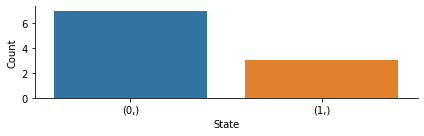

In [15]:
def plot_counts(counts):
    counts_record = [{"State":state, "Count":count} for state, count in counts.items()]
    count_df = pd.DataFrame().from_records(counts_record)
    sns.catplot(x="State", y="Count", kind="bar", data=count_df, aspect=3, height=2 )
    plt.show()
    
plot_counts(counts)

### Testing Slightly More Complex Circuits

Still taking from the sample code online, we now try applying an assortment of gates

In [17]:
n_qubits = 3
n_bits = 3
circ2 = Circuit(n_qubits, n_bits)
circ2.Rx(0.5, 1) #X rotation by pi/2 on qubit 1
circ2.Rz(0.25, 0)
circ2.CX(0,2) #CNOT gate between qubits 0 and 2
circ2.measure_all()
render_circuit_jupyter(circ2)

Counter({(0, 0, 0): 14, (0, 1, 0): 6})


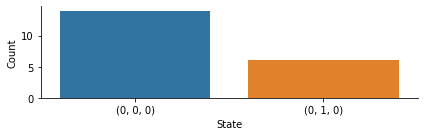

In [20]:
handle2 = backend.process_circuit(circ2, n_shots = 20, seed = 1)
shots2 = backend.get_result(handle2).get_shots()
counts2 = backend.get_result(handle2).get_counts()
print(counts2)
plot_counts(counts2)

### Converting Between `qiskit` and `pytket`

Using `tk_to_qiskit` and `qiskit_to_tk`

In [21]:
#Imports
from qiskit import QuantumCircuit
from math import pi
from pytket.extensions.qiskit import qiskit_to_tk, tk_to_qiskit

In [25]:
qc = QuantumCircuit(3) #Quantum circuit with 3 qubits
qc.h(0) #Hadamard on qubit 0
qc.cx(0,1) #Controlled NOT gate between qubits 0 and 1
qc.rz(pi/2, 1) #Rz gate rotation by pi/2 on qubit 1

print(qc)

     ┌───┐                
q_0: ┤ H ├──■─────────────
     └───┘┌─┴─┐┌─────────┐
q_1: ─────┤ X ├┤ Rz(π/2) ├
          └───┘└─────────┘
q_2: ─────────────────────
                          


In [26]:
circ = qiskit_to_tk(qc)
circ.CX(1,2)
render_circuit_jupyter(circ)

In [27]:
qc2 = tk_to_qiskit(circ)
print(qc2)

     ┌───┐                     
q_0: ┤ H ├──■──────────────────
     └───┘┌─┴─┐┌─────────┐     
q_1: ─────┤ X ├┤ Rz(π/2) ├──■──
          └───┘└─────────┘┌─┴─┐
q_2: ─────────────────────┤ X ├
                          └───┘


In [28]:
qc2.draw()

┌───┐                     
q_0: ┤ H ├──■──────────────────
     └───┘┌─┴─┐┌─────────┐     
q_1: ─────┤ X ├┤ Rz(π/2) ├──■──
          └───┘└─────────┘┌─┴─┐
q_2: ─────────────────────┤ X ├
                          └───┘

For this project, we will be using IBM's assortment of quantum chips. In the interest of time, we will not be using Cirq. 

### Importing QASM files

Using sample circuits saved as QASM files as provided [here](https://github.com/spendierk/ethz-hackathon22/tree/main/benchmarking/circuits).

In [29]:
#Imports
from pytket import Circuit, Qubit
from pytket.qasm import circuit_to_qasm, circuit_from_qasm

In [31]:
qasmfile = "8d1eb48e-d667-11ea-9cd7-38f9d36dfbf2.qasm"
qc4 = circuit_from_qasm(qasmfile)
qc4_qiskit = tk_to_qiskit(qc4)
qc4_qiskit.draw()

┌───────────┐  ┌────────────┐┌────────────┐┌─────────┐┌─────────┐»
q_0: ┤ Rz(6.263) ├──┤ Rx(2.5934) ├┤ Rz(2.9639) ├┤ Rz(π/2) ├┤ Rz(π/2) ├»
     ├───────────┴┐┌┴────────────┤├────────────┤└─────────┘└─────────┘»
q_1: ┤ Rz(2.1936) ├┤ Rx(0.48946) ├┤ Rz(2.5596) ├──────────────────────»
     └────────────┘└─────────────┘└────────────┘                      »
c: 2/═════════════════════════════════════════════════════════════════»
                                                                      »
«     ┌─────────┐┌─────────┐   ┌─────────┐  ┌─────────┐  ┌─────────┐»
«q_0: ┤ Rx(π/2) ├┤ Rz(π/2) ├─■─┤ Rz(π/2) ├──┤ Rx(π/2) ├──┤ Rz(π/2) ├»
«     └─────────┘└─────────┘ │ ├─────────┴┐┌┴─────────┴─┐├─────────┤»
«q_1: ───────────────────────■─┤ Rz(3π/2) ├┤ Rx(5.4177) ├┤ Rz(π/2) ├»
«                              └──────────┘└────────────┘└─────────┘»
«c: 2/══════════════════════════════════════════════════════════════»
«                                                                   »
«     ┌─────────────┐                         ┌─────────┐┌─────────┐┌─────────┐»
«q_0: ┤ Rz(0.22002) ├───────────────────────■─┤ Rz(π/2) ├┤ Rx(π/2) ├┤ Rz(π/2) ├»
«     └─┬─────────┬─┘┌─────────┐┌─────────┐ │ ├─────────┤├─────────┤├─────────┤»
«q_1: ──┤ Rz(π/2) ├──┤ Rx(π/2) ├┤ Rz(π/2) ├─■─┤ Rz(π/2) ├┤ Rx(π/2) ├┤ Rz(π/2) ├»
«       └─────────┘  └─────────┘└─────────┘   └─────────┘└─────────┘└─────────┘»
«c: 2/═════════════════════════════════════════════════════════════════════════»
«                                                                              »
«                                             ┌─────────┐  ┌─────────┐  »
«q_0: ──────────────────────────────────────■─┤ Rz(π/2) ├──┤ Rx(π/2) ├──»
«     ┌──────────┐┌────────────┐┌─────────┐ │ ├─────────┴┐┌┴─────────┴─┐»
«q_1: ┤ Rz(3π/2) ├┤ Rx(1.5622) ├┤ Rz(π/2) ├─■─┤ Rz(3π/2) ├┤ Rz(3.1643) ├»
«     └──────────┘└────────────┘└─────────┘   └──────────┘└────────────┘»
«c: 2/══════════════════════════════════════════════════════════════════»
«                                                                       »
«      ┌─────────┐  ┌────────────┐ ┌────────────┐┌────────────┐┌────────────┐»
«q_0: ─┤ Rz(π/2) ├──┤ Rz(4.1536) ├─┤ Rx(1.1211) ├┤ Rz(2.2397) ├┤ Rz(1.6988) ├»
«     ┌┴─────────┴─┐├────────────┤┌┴────────────┤├────────────┤├────────────┤»
«q_1: ┤ Rx(2.9469) ├┤ Rz(4.0259) ├┤ Rz(0.87401) ├┤ Rx(1.9507) ├┤ Rz(2.5005) ├»
«     └────────────┘└────────────┘└─────────────┘└────────────┘└────────────┘»
«c: 2/═══════════════════════════════════════════════════════════════════════»
«                                                                            »
«     ┌────────────┐┌────────────┐┌─────────┐┌─────────┐┌─────────┐┌─────────┐»
«q_0: ┤ Rx(1.2824) ├┤ Rz(3.8503) ├┤ Rz(π/2) ├┤ Rz(π/2) ├┤ Rx(π/2) ├┤ Rz(π/2) ├»
«     └────────────┘└────────────┘└─────────┘└─────────┘└─────────┘└─────────┘»
«q_1: ────────────────────────────────────────────────────────────────────────»
«                                                                             »
«c: 2/════════════════════════════════════════════════════════════════════════»
«                                                                             »
«        ┌─────────┐  ┌─────────┐  ┌─────────┐┌─────────────┐           »
«q_0: ─■─┤ Rz(π/2) ├──┤ Rx(π/2) ├──┤ Rz(π/2) ├┤ Rz(0.12851) ├───────────»
«      │ ├─────────┴┐┌┴─────────┴─┐├─────────┤└─┬─────────┬─┘┌─────────┐»
«q_1: ─■─┤ Rz(3π/2) ├┤ Rx(5.6561) ├┤ Rz(π/2) ├──┤ Rz(π/2) ├──┤ Rx(π/2) ├»
«        └──────────┘└────────────┘└─────────┘  └─────────┘  └─────────┘»
«c: 2/══════════════════════════════════════════════════════════════════»
«                                                                       »
«                   ┌─────────┐┌─────────┐┌─────────┐                          »
«q_0: ────────────■─┤ Rz(π/2) ├┤ Rx(π/2) ├┤ Rz(π/2) ├──────────────────────────»
«     ┌─────────┐ │ ├─────────┤├─────────┤├─────────┤┌──────────┐┌────────────┐»
«q_1: ┤ Rz(π/2) ├─■─┤ Rz(π/2) ├┤ Rx(π/2) ├┤ Rz(π/2) 